# Image Compression using Discrete Cosine Transform

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft

## Discrete Cosine Transform

### Some helper functions

In [2]:
def EvenExtension(f):
    '''
     fe = EvenExtension(f)
     
     Performs an even extension on the array f.
    
     Input:
       f is a 2D array
    
     Output:
       fe is the even extension of f
    
     If f has dimensions NxM, then fe has dimensions
        (2*N-2)x(2*M-2)
     and fe[n,j]=fe[-n,j] for n=0,...,N-1
     and fe[n,j]=fe[n,-j] for j=0,...,M-1
    
     For example, if f is 5x4, then fe has dimensions 8x6.
    
     IEvenExtension is the inverse of EvenExtension, so that
        IEvenExtension(EvenExtension(f)) == f
     for any matrix f.
    
    '''
    fe = np.concatenate((f,np.fliplr(f[:,1:-1])), axis=1)
    fe = np.concatenate((fe, np.flipud(fe[1:-1,:])), axis=0)
    
    return fe

def IEvenExtension(fe):
    '''
     f = IEvenExtension(fe)
    
     Reverses the action of an even extension.
    
     Input:
       fe is a 2D array, assumed to contain an even extension
    
     Output:
       f is the sub-array that was used to generate the extension
    
     If fe has dimensions KxL, then f has dimensions
        ceil((K+1)/2) x ceil((L+1)/2)
     For example, if fe is 8x6, then f is 5x4.
    
     IEvenExtension is the inverse of EvenExtension, so that
        IEvenExtension(EvenExtension(f)) == f
     for any matrix f.
    
    '''
    e_dims = np.array(np.shape(fe))
    dims = np.ceil((e_dims+1.)/2)
    dims = np.array(dims, dtype=int)
    f = fe[:dims[0], :dims[1]]
    #f = fe(1:dims(1),1:dims(2));
    return f

In [3]:
# First, a simple 1D example.
f = np.array([[1,2,3,4,5]])
fe = EvenExtension(f)
print(fe)

[[1 2 3 4 5 4 3 2]]


In [4]:
# Define a simple 2-D array to play with
f = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]], dtype=float)
print(f)

[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]]


In [5]:
# Even extension
fe = EvenExtension(f)
print(fe)

[[ 1.  2.  3.  4.  3.  2.]
 [ 5.  6.  7.  8.  7.  6.]
 [ 9. 10. 11. 12. 11. 10.]
 [ 5.  6.  7.  8.  7.  6.]]


In [6]:
# Check that it's even
n = np.random.randint(np.shape(f)[0])
j = np.random.randint(np.shape(f)[1])
print((n,j))
print(fe[n,j])
print(fe[-n,-j])

(1, 2)
7.0
7.0


In [7]:
# Inverse even extension
g = IEvenExtension(fe)
print(g)


[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]]


### `DCT`

In [8]:

def DCT(f):
    '''
     F = DCT(f)
    
     Computes the 2-D Discrete Cosine Transform of input image f.
     It uses an even extension of f, along with the 2D-DFT.
     This function is the inverse of myIDCT.
    
     Input:
      f is a 2-D array of real values
    
     Output:
      F is a real-valued array the same size as f
    '''
    F = np.zeros_like(f)

    N = len(f)
    N1 = len(f[1])
    #print(N)
    g = EvenExtension(f)
    dft2 = fft.fft2(g)
    F = dft2[:N, :N1]

    return(np.real(F))





### `IDCT`

In [9]:
def IDCT(F):
    '''
     f = IDCT(F)
    
     Computes the 2-D Inverse Discrete Cosine Transform (IDCT) of input
     array Fdct. It uses an even extension of Fdct, along with the 2D-IDFT.
     This function is the inverse of myDCT.
    
     Input:
      F is a 2-D array of real values
    
     Output:
      f is a real-valued array the same size as Fdct
    '''
    f = np.zeros_like(F)
    
    N = len(F)
    
    df = EvenExtension(F)
    df1 = fft.ifft2(df)

    f = IEvenExtension(df1)
    return(np.real(f))



## Image Compression Time

In [10]:
# Helper Functions
def NumPixels(f):
    '''
     n = NumPixels(f) returns the total number of elements in the array f.
     
     For example,
       NumPixels( np.ones((5,4)) )
     returns the value 20.
    '''
    return np.prod(np.shape(f))

def Show(g, title=''):
    '''
     Show(g, title='')
     
     Displays the image g as a graylevel image with intensities
     clipped to the range [0,255].
    '''
    plt.imshow(np.clip(g, a_min=0, a_max=255), cmap='gray')
    plt.axis('off');
    plt.title(title)

### Compress

In [11]:
def Compress(f, T, D):
    '''
     G = Compress(f, T, D)
    
     Input
        f is the input image, a 2D array of real numbers
        T is the tile size to break the input image into
        D is the size of the block of Fourier coefficients to keep
          (Bigger values of D result in less loss, but less compression)
    
     Output
        G is the compressed encoding of the image
    
     Example: If f is 120x120, then
    
        G = Compress(f, 10, 4)
    
     would return an array (G) of size 48x48.
    '''
    h,w = np.shape(f)  # returns the width and height of f
    r = int(np.floor(h/T))
    c = int(np.floor(w/T))
    G = np.zeros( (int(np.floor(h/T)*D), int(np.floor(w/T)*D)) ) # this is not guaranteed to be the right size

   
    for i in range(0, r):
       for j in range(0, c):

          blk = f[i*T:(i+1)*T, j*T:(j+1)*T]
          #print(blk)
          dct = DCT(blk)
          dct1 = dct[0:D,0:D] # D x D of low frequency coefficients
          
          G[i*D:(i+1)*D,j*D:(j+1)*D] = dct1

    #print(G)
    return G



### `Decompress`

In [12]:
def Decompress(G, T, D):
    '''
     f = Decompress(G, T, D)
    
     Input
        G is the compressed encoding, a 2D array of real numbers
        T is the tile size for reassembling the decompressed image
        D is the size of the blocks of Fourier coefficients that were
          kept when the image was compressed
          (Bigger values of D result in less loss, but less compression)
    
     Output
        f is the decompressed, reconstructed image
    
     Example: If G is 48x48, then
    
        f = Decompress(G, 10, 4);
    
     would return an array (f) of size 120x120.
    '''
    n_hblocks = int( np.shape(G)[0]/D )
    n_wblocks = int( np.shape(G)[1]/D )
    
    f = np.zeros( (T*n_hblocks, T*n_wblocks) )
    
    wblocks = np.arange(0, np.shape(f)[1], T)
    hblocks = np.arange(0, np.shape(f)[0], T)
    

    for i in range(0, n_hblocks):
      for j in range(0, n_wblocks):
         blk = np.zeros((T,T))

         blk[0:D, 0:D] = G[i*D:(i+1)*D, j*D:(j+1)*D] # embed DxD array of DCT coefficients back into TxT array

         dct = IDCT(blk)
         
         f[i*T:(i+1)*T,j*T:(j+1)*T] = dct
      
    #print(G)
      



    return f



### Demonstrate Compression

120000


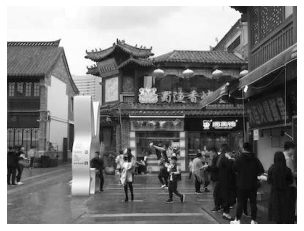

In [13]:
f = plt.imread('jinan.jpg')[:,:,0]
Show(f)

print(NumPixels(f))

In [14]:
# Set the tile size
T = 10

In [15]:
# Compression ratio 2:1
compress2 = Compress(f, 10, 7)
decompress2 = Decompress(compress2,10,7)


print(NumPixels(compress2)) # 120000 / 58800 is roughly 2


58800


In [16]:
# Compression ratio 4:1
compress4 = Compress(f, 10, 5)
decompress4 = Decompress(compress4,10,5)


print(NumPixels(compress4)) # 120000 / 30000 is 4


30000


In [17]:
# Compression ratio 25:1

compress25 = Compress(f, 10, 2)
decompress25 = Decompress(compress25,10,2)


print(NumPixels(compress25)) # 120000 / 4800 is 25



4800


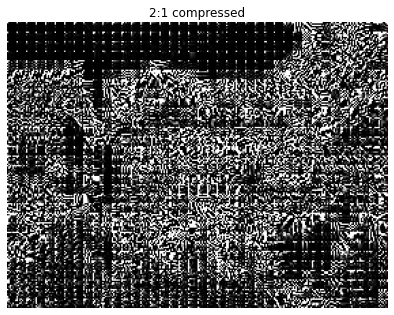

In [18]:

plt.figure(figsize=(15,12))
plt.subplot(2,2,1); Show(f, title='Original');

Show(compress2, title = '2:1 compressed')


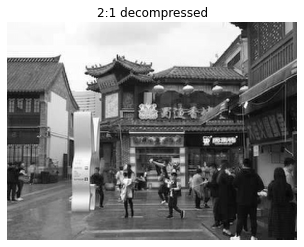

In [19]:
Show(decompress2, title = '2:1 decompressed')


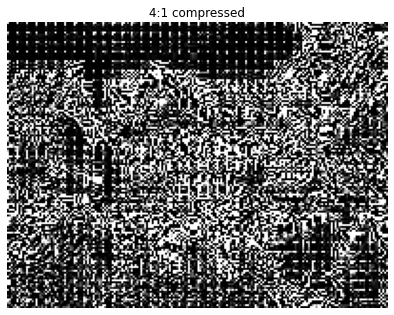

In [20]:
plt.figure(figsize=(15,12))
plt.subplot(2,2,1); Show(f, title='Original');
Show(compress4, title = '4:1 compressed')



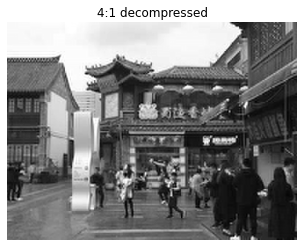

In [21]:
Show(decompress4, title = '4:1 decompressed')


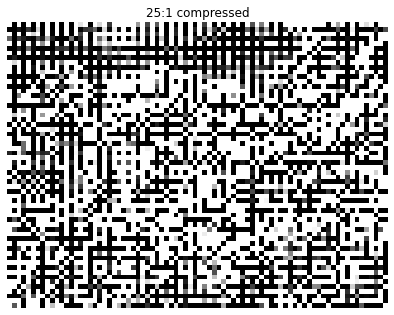

In [22]:
plt.figure(figsize=(15,12))
plt.subplot(2,2,1); Show(f, title='Original');
Show(compress25, title = '25:1 compressed')


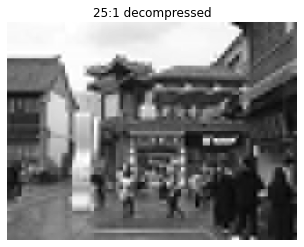

In [23]:
Show(decompress25, title = '25:1 decompressed')
